In [1]:
import os
import numpy as np
import pynbody
from pynbody.plot import sph
import matplotlib.pylab as plt
# plt.style.use('dark_background')

import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
from snap_io import load_moria_sim_and_kicked, load_moria, load_kicked, load_sim

In [2]:
import contextlib

@contextlib.contextmanager
def np_printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

In [3]:
SIMNUMBER = "69002_p200.0_a600.0_r600.0_c8.15_z0"
kicked=True

In [4]:
resolution = 500
width = 10 # kpc
vmax=2e-1
vmin=5e-4;

In [5]:
snap_list = load_kicked(SIMNUMBER) if kicked else load_moria(SIMNUMBER)

In [6]:
s = snap_list[0]
s

<SimSnap "/home/michele/sim/MySimulations/Moria8Gyr_tidal/sim69002_p200.0_a600.0_r600.0_c8.15_z0/out/snapshot_0001" len=1871020>

In [7]:
def gas_velocity_lateral_view(sim, **kwargs):
    """Returns an image where the x-axis is aligned with the overall mean velocity of
    the snaphot and the vertical axis is the z axis rotated by the elevation angle
    of the velocity"""
    sim.properties.pop('boxsize', None)
    sim.g['smooth'] /= 2
    pynbody.analysis.halo.center(sim)
    velocity = sim['vel'].mean(axis=0)
    backup = sim.g['pos'].copy()
    backup_v = sim.g['vel'].copy()
    v_xy = np.linalg.norm(velocity[0:2])
    v_x, v_y, v_z = velocity
    alpha = np.sign(v_y) * np.arccos(v_x/v_xy) * 180.0/np.pi
    theta = np.arctan(v_z/v_xy) * 180.0/np.pi
    r1=sim.g.rotate_z(alpha)
    r2=sim.g.rotate_y(theta)
    try:
        snap = int(sim.filename[-4:])
        with np_printoptions(precision=2):
            title = '$t={:5.2f}$ Gyr, snap={}\nv = {}'.format(sim.properties['time'].in_units("Gyr"), snap, velocity)
        img = sph.image(sim.g, qty="rho", units="g cm^-2", title=title, **kwargs)
    finally:
        # revert is costly (7% for each transformation w.r.t. the sph.image function)
        # and does not work when the transformation has been applied on a particle family
#         r2.revert()
#         r1.revert()
        sim.g['smooth'] *= 2
        sim.g['pos'] = backup
        sim.g['vel'] = backup_v
    return img

In [8]:
%load_ext line_profiler

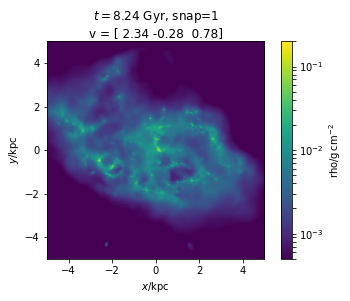

Timer unit: 1e-06 s

Total time: 1.48721 s
File: <ipython-input-7-de61da58ea11>
Function: gas_velocity_lateral_view at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def gas_velocity_lateral_view(sim, **kwargs):
     2                                               """Returns an image where the x-axis is aligned with the overall mean velocity of
     3                                               the snaphot and the vertical axis is the z axis rotated by the elevation angle
     4                                               of the velocity"""
     5         1            7      7.0      0.0      sim.properties.pop('boxsize', None)
     6         1        22438  22438.0      1.5      sim.g['smooth'] /= 2
     7         1       305239 305239.0     20.5      pynbody.analysis.halo.center(sim)
     8         1        26030  26030.0      1.8      velocity = sim['vel'].mean(axis=0)
     9         1         1025   1025.0

In [9]:
%lprun -f gas_velocity_lateral_view gas_velocity_lateral_view(s, width=width, vmin=vmin, vmax=vmax, resolution=resolution)

In [10]:
vmax=2e-1
vmin=5e-4;

In [11]:
vminmax = ipywidgets.FloatRangeSlider(
    value=[vmin, vmax],
    min=1e-6,
    max=1e-2,
    step=1e-5,
    description='Value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='1.0e',
)
snap_slider = ipywidgets.IntSlider(min=0,max=len(snap_list),step=1,value=0, continuous_update=False, description='Snap:')
width_slider = ipywidgets.IntSlider(min=5,max=1000,step=10,value=20, continuous_update=False, description='Width (kpc):')
res_slider = ipywidgets.IntSlider(min=100,max=1000,step=100,value=200, continuous_update=False, description='Resol. (pix):')

def k(i, vrange, width, resolution):
    gas_velocity_lateral_view(snap_list[i], width=width, vmin=vrange[0], vmax=vrange[1], resolution=resolution)

In [12]:
interact(k, i=snap_slider, vrange=vminmax, width=width_slider, resolution=res_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='Snap:', max=95), FloatRangeSlider(value=(0.0005, 0.01), continuous_update=False, description='Value:', max=0.01, min=1e-06, readout_format='1.0e', step=1e-05), IntSlider(value=20, continuous_update=False, description='Width (kpc):', max=1000, min=5, step=10), IntSlider(value=200, continuous_update=False, description='Resol. (pix):', max=1000, min=100, step=100), Output()), _dom_classes=('widget-interact',))

In [13]:
def plot_stars_projected(sim, **kwargs):
    """Wrapper around pynbody.plot.stars.render using correct smoothing length"""
    sim.properties.pop('boxsize', None)
    sim.g['smooth'] /= 2
    pynbody.analysis.halo.center(sim)
    velocity = sim['vel'].mean(axis=0)
    backup = sim.s['pos'].copy()
    backup_v = sim.s['vel'].copy()
    v_xy = np.linalg.norm(velocity[0:2])
    v_x, v_y, v_z = velocity
    alpha = np.sign(v_y) * np.arccos(v_x/v_xy) * 180.0/np.pi
    theta = np.arctan(v_z/v_xy) * 180.0/np.pi
    r1=sim.s.rotate_z(alpha)
    r2=sim.s.rotate_y(theta)
    try:
        snap = int(sim.filename[-4:])
        with np_printoptions(precision=2):
            title = '$t={:5.2f}$ Gyr, snap={}\nv = {}'.format(sim.properties['time'].in_units("Gyr"), snap, velocity)
        img =  pynbody.plot.stars.render(sim, title=title, **kwargs)
    finally:
        # revert is costly (7% for each transformation w.r.t. the sph.image function)
        # and does not work when the transformation has been applied on a particle family
#         r2.revert()
#         r1.revert()
        sim.g['smooth'] *= 2
        sim.g['pos'] = backup
        sim.g['vel'] = backup_v
    return img

In [14]:
def h(i, width):
    pynbody.plot.stars.render(sim=snap_list[i], width=width)

In [20]:
snap_slider_star = ipywidgets.IntSlider(min=0,max=len(snap_list),step=1,value=0, continuous_update=False, description='Snap:')
width_slider_star = ipywidgets.IntSlider(min=1,max=200,step=5,value=20, continuous_update=False, description='Width (kpc):')
interact(h, i=snap_slider_star, width=width_slider_star);

interactive(children=(IntSlider(value=0, continuous_update=False, description='Snap:', max=95), IntSlider(value=20, continuous_update=False, description='Width (kpc):', max=200, min=1, step=5), Output()), _dom_classes=('widget-interact',))

In [16]:
def sbprof(i, band, rmax):
    pynbody.plot.stars.sbprofile(snap_list[i], band=band, rmax=rmax)
    
bands=["U", "B", "V", "R", "I", "J", "H", "K"]

bands_button = ipywidgets.Dropdown(
    options=list(map(str.lower,bands)),
    value='v',
    description='Band:',
    disabled=False
)
snap_slider_sbprof = ipywidgets.IntSlider(min=0,max=len(snap_list),step=1,value=0, continuous_update=False, description='Snap:')
rmax_slider = ipywidgets.IntSlider(min=5,max=1000,step=10,value=20, continuous_update=False, description='Rmax (kpc):')
interact(sbprof, i=snap_slider_sbprof, band=bands_button, rmax=rmax_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Snap:', max=95), Dropdown(description='Band:', index=2, options=('u', 'b', 'v', 'r', 'i', 'j', 'h', 'k'), value='v'), IntSlider(value=20, continuous_update=False, description='Rmax (kpc):', max=1000, min=5, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.sbprof>

In [17]:
# folder = "pngs_{}".format(SIMNUMBER)
# os.makedirs(folder,exist_ok=True )

In [18]:
# for sim in snap_list[0:3]:
#     snap = int(sim.filename[-4:])
#     fig, ax = plt.subplots(figsize=(15,15))
#     filename = os.path.join(folder,"gas_image_{}_{}.png".format(SIMNUMBER,snap))
#     title = '$t={:5.2f}$ Gyr, snap={}'.format(sim.properties['time'].in_units("Gyr"), snap)
#     gas_image(sim, width=width, vmin=vmin, vmax=vmax, resolution=resolution, title=title, filename=filename);
#     print("Saved", filename)